<a href="https://colab.research.google.com/github/leemichaelwaters/united-airlines-take-home-task/blob/main/Flights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

## Dataset

*2015 Flight Delays and Cancellations Kaggle Dataset*
* This collection of data contains three different datasets: `airlines.csv`, `airports.csv`, and `flights.csv`
* Metadata information is available about the files on the [kaggle website](https://www.kaggle.com/datasets/usdot/flight-delays)

## Questions

With these datasets, we would like you to investigate the following questions:
* ~Which airlines performs the worst? Which the best?~
* ~Does airline performance change over the months of the year? In other words, is one airline always the worst performing or is there variability?~
* ~Do certain routes commonly end up delayed or canceled across all airlines?~
* ~Create a forecast for the count of cancellations on United Airlines flights with destinations in the state of California in the month of December~

## Deliverables

* ~Please prepare a 10-minute presentation summarizing your findings~
* ~Be sure to include recommendations on areas where the business could focus its efforts based off your findings~
* ~Be prepared to answer a few follow-up questions on your work~

## Expectations

* ~We are less concerned with right answers and more interested in seeing your process for this exercise~
* ~You may use any application(s), tool(s), or programming language(s) to complete your analysis~
* ~You are allowed to use external resources to complete this exercise (e.g. looking something up on StackOverflow)~
* ~**Please submit all files, including code, visualizations, and slides that you used to answer the questions by 9AM Central the day of your interview. You should email these materials to greg.jackson@united.com.**~

# Setup



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_absolute_error

# Import data

In [ ]:
df = pd.read_csv('datasets/flights/flights.csv', dtype={'ORIGIN_AIRPORT': 'str', 'DESTINATION_AIRPORT': 'str'})  # Fixing DtypeWarning: Columns (7,8) have mixed types

In [ ]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

## Which airlines performs the worst? Which the best?

In [ ]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 5819079 non-null  int64  
 1   MONTH                5819079 non-null  int64  
 2   DAY                  5819079 non-null  int64  
 3   DAY_OF_WEEK          5819079 non-null  int64  
 4   AIRLINE              5819079 non-null  object 
 5   FLIGHT_NUMBER        5819079 non-null  int64  
 6   TAIL_NUMBER          5804358 non-null  object 
 7   ORIGIN_AIRPORT       5819079 non-null  object 
 8   DESTINATION_AIRPORT  5819079 non-null  object 
 9   SCHEDULED_DEPARTURE  5819079 non-null  int64  
 10  DEPARTURE_TIME       5732926 non-null  float64
 11  DEPARTURE_DELAY      5732926 non-null  float64
 12  TAXI_OUT             5730032 non-null  float64
 13  WHEELS_OFF           5730032 non-null  float64
 14  SCHEDULED_TIME       5819073 non-null  float64
 15

* Approximately 6M flights
* Investigate missing values

In [ ]:
df_performance = df.copy()
df_performance = df_performance[['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'CANCELLED']]

In [ ]:
df_missing = df_performance.isnull().sum(axis=0).reset_index()  # reset_index() turns series into dataframe
df_missing.columns = ['Feature', 'Null']
df_missing['Missing %'] = round((df_missing['Null']) / df_performance.shape[0] * 100, 0)
df_missing.sort_values('Missing %', ascending=False).reset_index(drop=True)

,Feature,Null,Missing %
0,ARRIVAL_DELAY,105071,2.0
1,DEPARTURE_DELAY,86153,1.0
2,YEAR,0,0.0
3,MONTH,0,0.0
4,DAY,0,0.0
5,AIRLINE,0,0.0
6,ORIGIN_AIRPORT,0,0.0
7,DESTINATION_AIRPORT,0,0.0
8,CANCELLED,0,0.0


* Only 2% of 6M records are missing data
* Check if "missing" delays correspond to cancellations

In [ ]:
df_performance[df_performance['ARRIVAL_DELAY'].isnull() | df_performance['DEPARTURE_DELAY'].isnull()]

,YEAR,MONTH,DAY,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLED
32,2015,1,1,AS,NaN,NaN,ANC,SEA,1
42,2015,1,1,AA,NaN,NaN,PHX,DFW,1
68,2015,1,1,OO,NaN,NaN,MAF,IAH,1
82,2015,1,1,MQ,NaN,NaN,SGF,DFW,1
90,2015,1,1,OO,NaN,NaN,RDD,SFO,1
...,...,...,...,...,...,...,...,...,...
5818157,2015,12,31,UA,NaN,NaN,SFO,LAX,1
5818160,2015,12,31,WN,13.0,NaN,MDW,ABQ,0
5818318,2015,12,31,AA,NaN,NaN,MIA,SAN,1
5818777,2015,12,31,NK,NaN,NaN,FLL,IAG,1


* `CANCELLED` flag appears when `DEPARTURE_DELAY` and `ARRIVAL_DELAY` are `NaN`
* `ARRIVAL_DELAY` `NaN` when `DEPARTURE_DELAY`
* Drop nulls for delay performance analysis

In [ ]:
df_performance.dropna(inplace=True)

In [ ]:
df_performance['TOTAL_DELAY'] = df_performance['DEPARTURE_DELAY'] + df_performance['ARRIVAL_DELAY']

In [ ]:
airline_avg_delay_per_min = df_performance[['AIRLINE', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TOTAL_DELAY']].groupby('AIRLINE').mean()

In [ ]:
airline_avg_delay_per_min = airline_avg_delay_per_min.sort_values('TOTAL_DELAY', ascending=False)

In [ ]:
airline_avg_delay_per_min

,DEPARTURE_DELAY,ARRIVAL_DELAY,TOTAL_DELAY
AIRLINE,,,
NK,15.883101,14.471800,30.354900
F9,13.303352,12.504706,25.808059
UA,14.333056,5.431594,19.764650
B6,11.442467,6.677861,18.120328
MQ,9.967187,6.457873,16.425060
EV,8.615598,6.585379,15.200976
WN,10.517183,4.374964,14.892147
VX,8.993486,4.737706,13.731191
OO,7.736083,5.845652,13.581735


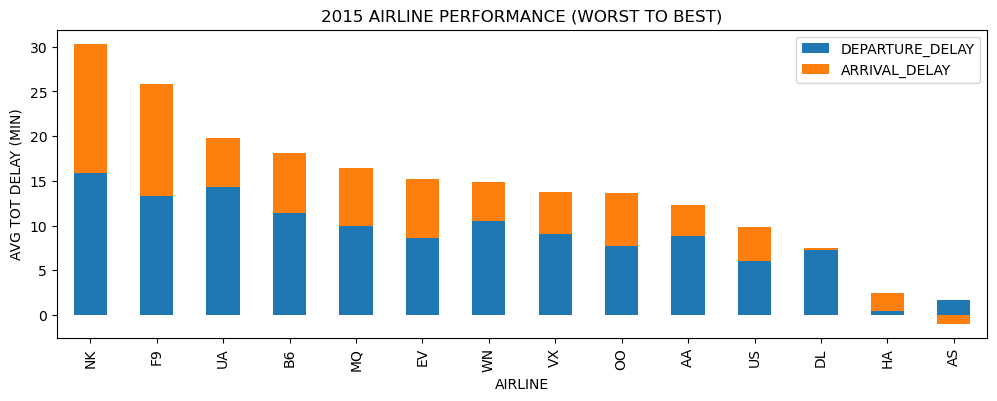

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
airline_avg_delay_per_min[['DEPARTURE_DELAY', 'ARRIVAL_DELAY']].plot.bar(ax=axs, stacked=True)
axs.set_ylabel('AVG TOT DELAY (MIN)')
axs.set_title('2015 AIRLINE PERFORMANCE (WORST TO BEST)')
fig.savefig('images/flights/airline_delay_performance.png')

* Spirit peforms the worst; Alaska Airlines performs the best
* United Airlines third worst performer
* United Airlines delays primarily from departures

## Does airline performance change over the months of the year? Is one airline always the worst performing or is there variability?

In [ ]:
df_performance.head()

,YEAR,MONTH,DAY,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLED,TOTAL_DELAY
0,2015,1,1,AS,-11.0,-22.0,ANC,SEA,0,-33.0
1,2015,1,1,AA,-8.0,-9.0,LAX,PBI,0,-17.0
2,2015,1,1,US,-2.0,5.0,SFO,CLT,0,3.0
3,2015,1,1,AA,-5.0,-9.0,LAX,MIA,0,-14.0
4,2015,1,1,AS,-1.0,-21.0,SEA,ANC,0,-22.0


In [ ]:
df_performance['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [ ]:
df_performance = df_performance[['DATE', 'AIRLINE', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'TOTAL_DELAY', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'CANCELLED']]

In [ ]:
df_performance.head()

,DATE,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,TOTAL_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLED
0,2015-01-01,AS,-11.0,-22.0,-33.0,ANC,SEA,0
1,2015-01-01,AA,-8.0,-9.0,-17.0,LAX,PBI,0
2,2015-01-01,US,-2.0,5.0,3.0,SFO,CLT,0
3,2015-01-01,AA,-5.0,-9.0,-14.0,LAX,MIA,0
4,2015-01-01,AS,-1.0,-21.0,-22.0,SEA,ANC,0


In [ ]:
airline_avg_delay_per_month = df_performance.groupby([df_performance['DATE'].dt.month, 'AIRLINE'])['TOTAL_DELAY'].mean()

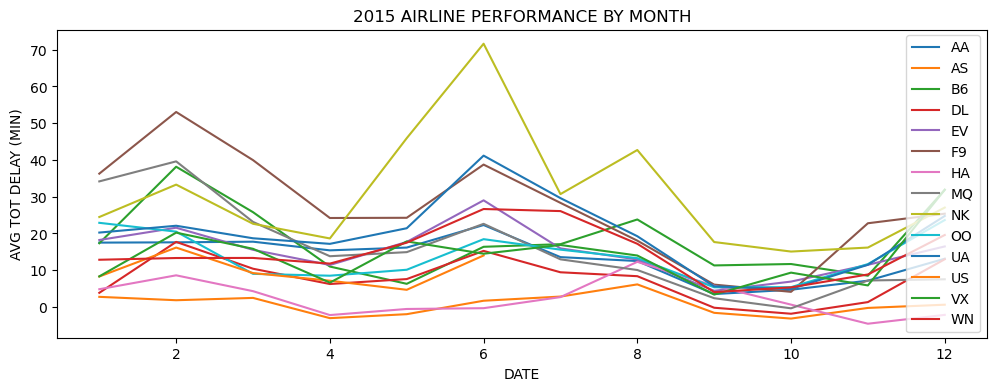

In [ ]:
fig, axs = plt.subplots(figsize=(12, 4))
airline_avg_delay_per_month.unstack(level='AIRLINE').plot(ax=axs).legend(loc='right')
axs.set_ylabel('AVG TOT DELAY (MIN)')
axs.set_title('2015 AIRLINE PERFORMANCE BY MONTH')
fig.savefig('images/flights/airline_delay_performance_by_month.png')

* Yes, airline performance displays seasonal variation with longer delays likely during peak demand periods (e.g. President's Day, Summer Holiday(s), Christmas, etc.)
* There is also variability in airline performance. For example, Frontier experienced the longest delays in February, Spirit in June, but Jet Blue in December

## Do certain routes commonly end up delayed or canceled across all airlines?

In [ ]:
df_performance['O&D'] = df_performance['ORIGIN_AIRPORT'] + '-' + df_performance['DESTINATION_AIRPORT']

In [ ]:
df_performance.head()

,DATE,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,TOTAL_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLED,O&D
0,2015-01-01,AS,-11.0,-22.0,-33.0,ANC,SEA,0,ANC-SEA
1,2015-01-01,AA,-8.0,-9.0,-17.0,LAX,PBI,0,LAX-PBI
2,2015-01-01,US,-2.0,5.0,3.0,SFO,CLT,0,SFO-CLT
3,2015-01-01,AA,-5.0,-9.0,-14.0,LAX,MIA,0,LAX-MIA
4,2015-01-01,AS,-1.0,-21.0,-22.0,SEA,ANC,0,SEA-ANC


In [ ]:
df_performance.sort_values('O&D')

,DATE,AIRLINE,DEPARTURE_DELAY,ARRIVAL_DELAY,TOTAL_DELAY,ORIGIN_AIRPORT,DESTINATION_AIRPORT,CANCELLED,O&D
4409221,2015-10-02,EV,-3.0,-3.0,-6.0,10135,10397,0,10135-10397
4849872,2015-10-30,EV,-8.0,-26.0,-34.0,10135,10397,0,10135-10397
4565290,2015-10-12,EV,-2.0,0.0,-2.0,10135,10397,0,10135-10397
4806789,2015-10-27,EV,-4.0,4.0,0.0,10135,10397,0,10135-10397
4653735,2015-10-18,DL,-5.0,-12.0,-17.0,10135,10397,0,10135-10397
...,...,...,...,...,...,...,...,...,...
5696500,2015-12-23,OO,51.0,57.0,108.0,YUM,PHX,0,YUM-PHX
4382266,2015-09-30,OO,-14.0,-22.0,-36.0,YUM,PHX,0,YUM-PHX
5613888,2015-12-18,OO,-11.0,-15.0,-26.0,YUM,PHX,0,YUM-PHX
98634,2015-01-07,OO,-4.0,-5.0,-9.0,YUM,PHX,0,YUM-PHX


* There exist rows where origin and destination are a number
* Remove for subsequent analysis

In [ ]:
df_od = df_performance[df_performance['ORIGIN_AIRPORT'].str.isalpha()]  # Remove rows where origin is number
df_od = df_performance[df_performance['DESTINATION_AIRPORT'].str.isalpha()]  # Remove rows where destination is number

In [ ]:
od_performance_delay = df_od[['O&D', 'TOTAL_DELAY']].groupby('O&D').mean().sort_values('TOTAL_DELAY', ascending=False).round(0)

In [ ]:
od_performance_delay['COUNT'] = df_od.groupby('O&D')['O&D'].count()

In [ ]:
od_performance_delay['AVG_DELAY_MIN'] = (od_performance_delay['TOTAL_DELAY'] / od_performance_delay['COUNT']).round(2)

In [ ]:
od_performance_delay[od_performance_delay['COUNT'] > 50].head()

,TOTAL_DELAY,COUNT,AVG_DELAY_MIN
O&D,,,
LGA-LIT,104.0,68,1.53
FAI-ORD,101.0,73,1.38
JFK-EGE,84.0,105,0.80
ASE-DFW,80.0,262,0.31
TYS-LGA,79.0,61,1.30


* Top 5 delayed O&Ds (minimum of 50 flights)
* Prevalance of O&Ds with travel between small/large airports
* Significant smaller delays than that for airlines
* Suggests airlines are problem not departing/receiving airports

In [ ]:
df_cancelled = df.copy()  # Cancelled flights do not have a delay (previously dropped), so need to grab from original dataset

In [ ]:
df_cancelled['O&D'] = df_cancelled['ORIGIN_AIRPORT'] + '-' + df_cancelled['DESTINATION_AIRPORT']  # Re-add O&D destination

In [ ]:
od_performance_cancelled = df_cancelled[['O&D', 'CANCELLED']].groupby('O&D').sum().sort_values('CANCELLED', ascending=False)

In [ ]:
od_performance_cancelled.head()

,CANCELLED
O&D,
BOS-LGA,443
LGA-BOS,441
LGA-ORD,435
ORD-LGA,408
LAX-SFO,342


* Top 5 cancelled O&Ds
* LGA, BOS, and ORD worst performers
* All major aiprots
* LGA also suffers major delays (see above)

## Create a forecast for the count of cancellations on United Airlines flights with destinations in the state of California in the month of December

In [ ]:
# Copy initial data with required columns
df_timeseries = df[['YEAR', 'MONTH', 'DAY', 'CANCELLED', 'DESTINATION_AIRPORT', 'AIRLINE']].copy()

In [ ]:
# Convert `YEAR`, `MONTH`, `DAY` to `datetime`
df_timeseries['DATE'] = pd.to_datetime(df_timeseries[['YEAR', 'MONTH', 'DAY']])

In [ ]:
# Read in airports data
airports = pd.read_csv('datasets/flights/airports.csv')

In [ ]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [ ]:
df_timeseries = pd.merge(df_timeseries, airports, how='left', left_on='DESTINATION_AIRPORT', right_on='IATA_CODE')

In [ ]:
# Filter only UA flights
df_timeseries = df_timeseries[df_timeseries['AIRLINE'] == 'UA']

In [ ]:
# Filter only CA destinations
df_timeseries = df_timeseries[df_timeseries['STATE'] == 'CA']

In [ ]:
df_timeseries.DATE.dt.month.unique()  # No Oct flights in CA

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12], dtype=int64)

In [ ]:
# Subset required columns
df_timeseries = df_timeseries[['DATE', 'CANCELLED']]

In [ ]:
# Groupby `DATE` (multiple flights on same day)
df_timeseries = df_timeseries.groupby('DATE').sum('CANCELLED')

In [ ]:
# Inspect data
df_timeseries

,CANCELLED
DATE,
2015-01-01,2
2015-01-02,0
2015-01-03,1
2015-01-04,2
2015-01-05,2
...,...
2015-12-27,11
2015-12-28,44
2015-12-29,16


In [ ]:
# Subset Jan-Nov for train set
train = df_timeseries['2015-01-01':'2015-11-30']

In [ ]:
# Subest Dec for test set
test = df_timeseries['2015-12-01':'2015-12-31']

In [ ]:
# Inspect data
train

,CANCELLED
DATE,
2015-01-01,2
2015-01-02,0
2015-01-03,1
2015-01-04,2
2015-01-05,2
...,...
2015-11-26,0
2015-11-27,0
2015-11-28,0


In [ ]:
# Inspect data
test

,CANCELLED
DATE,
2015-12-01,2
2015-12-02,0
2015-12-03,0
2015-12-04,0
2015-12-05,0
2015-12-06,0
2015-12-07,0
2015-12-08,0
2015-12-09,0


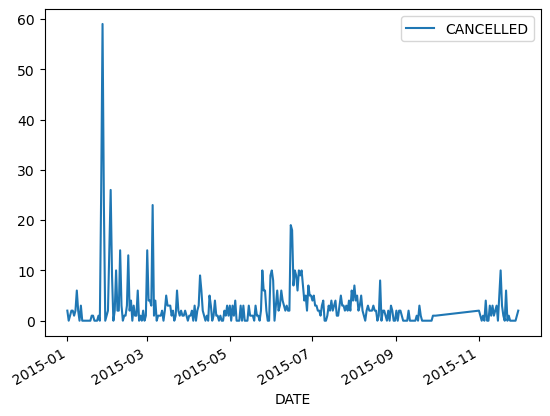

In [ ]:
train.plot();

### Stationarity

* ~Passes visual inspection of stationarity (constant mean and variance) with outlier occuring in Feb

In [ ]:
# Hypothesis test using Augmented Dickey-Fuller Test
adft = adfuller(train)

In [ ]:
df_adft = pd.DataFrame({"Values":[
                            adft[0],
                            adft[1],
                            adft[2],
                            adft[3],
                            adft[4]['1%'],
                            adft[4]['5%'],
                            adft[4]['10%']],
                        "Metric":[
                            "Test Statistics",
                            "p-value",
                            "No. lags used",
                            "No. observations used",
                            "Critical value (1%)",
                            "Critical value (5%)",
                            "Critical value (10%)"]})
print(df_adft)

       Values                 Metric
0   -4.293207        Test Statistics
1    0.000456                p-value
2    5.000000          No. lags used
3  297.000000  No. observations used
4   -3.452561    Critical value (1%)
5   -2.871321    Critical value (5%)
6   -2.571982   Critical value (10%)


* Fail to reject null hypothesis with p-val of 0.000456 which indicates stationarity

### Autocorrelation

In [ ]:
autocorrelation_lag1 = train['CANCELLED'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = train['CANCELLED'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = train['CANCELLED'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

One Month Lag:  0.48637968594841496
Three Month Lag:  0.02462542808678642
Six Month Lag:  0.2875704312751703


* Some positive correlation with one month lag

### Seasonality

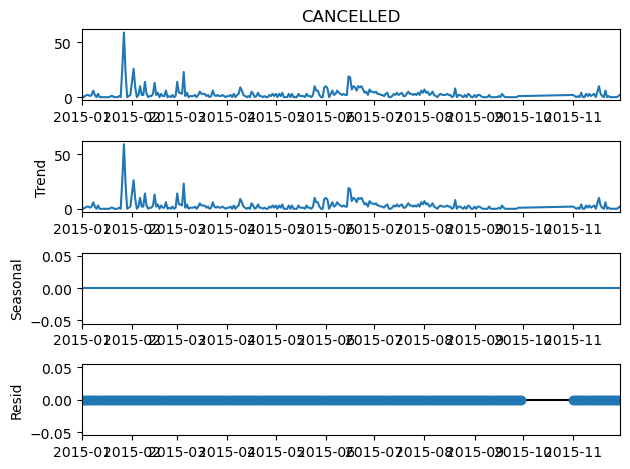

In [ ]:
decompose = seasonal_decompose(train['CANCELLED'], period=1)
decompose.plot()
plt.show()

* No trend
* No seasonal behavior

### Forecasting

In [ ]:
model = auto_arima(train)
model.fit(train)
predictions = model.predict(n_periods=len(test), index=test.index)
forecast = pd.DataFrame(predictions.array, index=test.index, columns=['PREDICTION'])

C:\Users\lee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


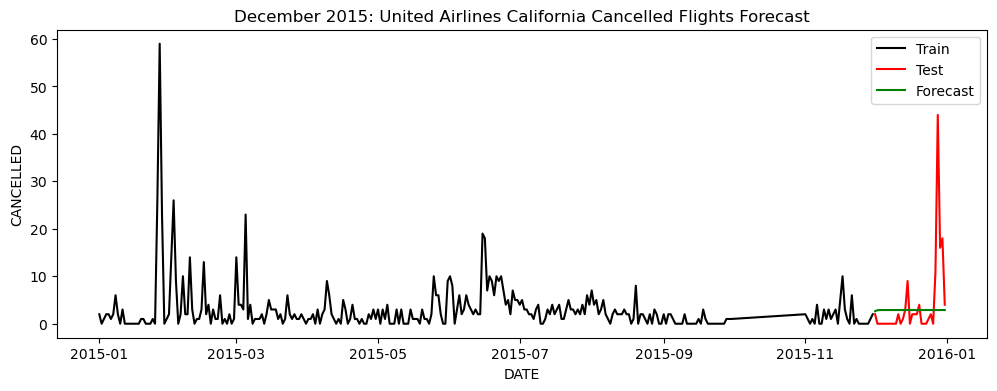

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(train, color='black', label='Train')
plt.plot(test, color='red', label='Test')
plt.plot(forecast, color='green', label='Forecast')
plt.legend()
plt.title('December 2015: United Airlines California Cancelled Flights Forecast')
plt.xlabel('DATE')
plt.ylabel('CANCELLED')
plt.show()
fig.savefig('images/flights/ua_dec_ca_forecast.png')

In [ ]:
mae = sqrt(mean_absolute_error(test, predictions))  # MAE rather than RMSE because of large outlier
print("MAE: ", round(mae, 2))  # Cancellations

MAE:  2.11


# Next steps

* Continue to develop time series model
    * No Oct flights
    * Different TSA methods
* Machine learning approach to predict cancellations
* Re-factor code